In [1]:
import struct
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
from utils.colmap_utils import (read_cameras_binary,
                                read_points3D_binary,
                                visualize_point_cloud, 
                                read_images_binary, 
                                create_transforms_json)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
cameras_file = "data/sparse/0/cameras.bin"
cameras_data = read_cameras_binary(cameras_file)

if cameras_data:
    first_camera_id = list(cameras_data.keys())[0]
    print(f"Camera {first_camera_id} info:")
    print(cameras_data[first_camera_id])

Camera 1 info:
{'model_id': 4, 'width': 960, 'height': 540, 'params': [556.9740875009339, 553.8176655260585, 480.0, 270.0, 0.00527160502148155, -0.007437133878853077, 0.0032169834001347657, 0.013468197350392126]}


Loaded 56042 points


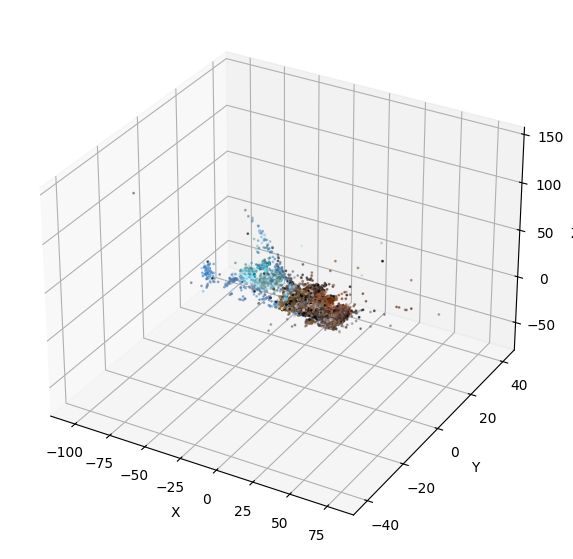

In [4]:
# points3D_file = "data/dense/dense_points3D.bin"
# not noticing significant difference between sparse / dense (from original gaussian-splatting repository)
points3D_file = "data/sparse/0/points3D.bin"
points3D_data = read_points3D_binary(points3D_file)

points = np.array([v["xyz"] for v in points3D_data.values()])
colors = np.array([v["rgb"] / 255.0 for v in points3D_data.values()])

print(f"Loaded {len(points)} points")

visualize_point_cloud(points, colors)